In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
ratings = pd.read_csv("../data/movielens/ratings.csv")

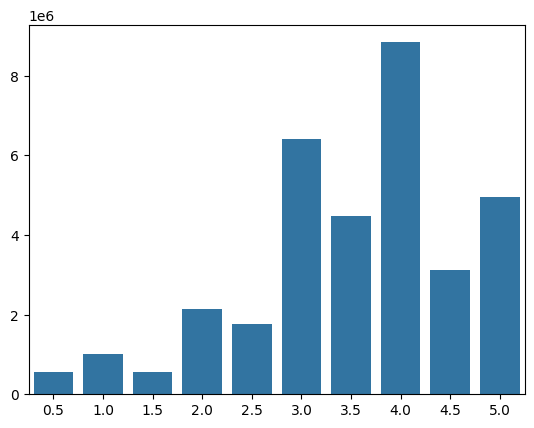

In [5]:
rating_distribution = ratings["rating"].value_counts().to_dict()
rating_distribution = dict(sorted(rating_distribution.items()))
sns.barplot(x=list(rating_distribution.keys()), y=list(rating_distribution.values()));

In [6]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [8]:
print(f"There are {ratings["user_id"].nunique()} users in the dataset.")
print(f"There are {ratings["movie_id"].nunique()} movies in the dataset.")
print(f"There are {ratings["rating"].shape[0]} ratings in the dataset.")

There are 330975 users in the dataset.
There are 83239 movies in the dataset.
There are 33832162 ratings in the dataset.


In [10]:
print(f"The average user has rated {ratings["rating"].shape[0] / ratings["user_id"].nunique():.0f} movies.")
print(f"The average movie has {ratings["rating"].shape[0] / ratings["movie_id"].nunique():.0f} ratings.")

The average user has rated 102 movies.
The average movie has 406 ratings.


In [18]:
user_rating_counts = ratings["user_id"].value_counts()
filtered_users = user_rating_counts[user_rating_counts >= 100].index
filtered_ratings = ratings[ratings["user_id"].isin(filtered_users)]

In [19]:
filtered_ratings

,user_id,movie_id,rating,timestamp
304,7,1,4.0,974518024
305,7,3,3.0,974517393
306,7,11,5.0,974520467
307,7,21,2.0,974518824
308,7,25,3.0,974519270
...,...,...,...,...
33832157,330975,8340,2.0,1091583256
33832158,330975,8493,2.5,1091585709
33832159,330975,8622,4.0,1091581777
33832160,330975,8665,3.0,1091581765


In [20]:
print(f"There are {filtered_ratings["user_id"].nunique()} users in the dataset.")

There are 82050 users in the dataset.
